In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
sys.path.append("../..")

import cge_modeling as cge
from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

from tests.utilities.models import load_model_2

In [2]:
variable_info = [
    # Firm Variables
    Variable(name="Y", dims="i", description="Total output of good <dim:i>"),
    Variable(name="VA", dims="i", description="Labor-capital bundle produced by sector <dim:i>"),
    Variable(
        name="VC", dims="i", description="Intermediate goods bundle produced by sector <dim:i>"
    ),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for sector <dim:i> goods by sector <dim:j>",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demanded by sector <dim:i>",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demanded by sector <dim:i>",
    ),
    Variable(name="L_s", description="Household labor supply"),
    # Household Variables
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of good <dim:i>"),
    Variable(name="C_total", latex_name="\bar{C}", description="Household consumption bundle"),
    Variable(name="F", description="Household leisure time"),
    #     Variable(name="income", latex_name="Omega", description="Total household income"),
    # Prices
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(name="CPI", latex_name="P_C", description="Price of the household consumption basket"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the labor-capital bundle in sector <dim:i>",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate bundle in sector <dim:i>",
    ),
    Variable(name="P", dims="i", description="Price level of final goods in sector <dim:i>"),
    # Other
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    # Firm Parameters
    Parameter(
        name="psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of labor-capital in sector <dim:i>'s final good",
    ),
    Parameter(
        name="psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of intermediate goods bundle in sector <dim:i>'s final product",
    ),
    Parameter(
        name="psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of sector <dim:i>'s final good in sector <dim:j>'s value chain bundle",
    ),
    Parameter(
        name="alpha",
        dims="i",
        description="Share of capital in sector <dim:i>'s production process",
    ),
    Parameter(
        name="phi_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(name="A", dims="i", description="Total factor productivity in sector <dim:i>"),
    # Household Parameters
    Parameter(
        name="sigma_C",
        description="Arrow-Pratt risk averson",
    ),
    Parameter(name="T", description="Time endowment"),
    Parameter(name="sigma_L", description="Inverse Frisch elasticity between work and leisure"),
    Parameter(name="Theta", description="Household labor dispreference parameter"),
    Parameter(name="phi_C", description="Elasticity of substitution between consumption goods"),
    Parameter(
        name="alpha_C",
        dims="i",
        extend_subscript=True,
        description="Share of <dim:i> in the household consumption bundle",
    ),
    Parameter(name="A_C", description="Household shopping technology"),
    # Exogenous variables
    Parameter(name="K_s", description="Exogenous household capital stock"),
    Parameter(name="P_bar", latex_name=r"\bar{P}", description="Exogenous CPI price level"),
]

equations = [
    # # Firm Equations
    # Final Goods
    Equation("Final good production of sector <dim:i>", "P * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC * P_VC = (P[:, None] * X).sum(axis=0).ravel()",
    ),
    Equation("Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC[None]"),
    # Value add bundle
    Equation(
        "Sector <dim:i> production of labor-capital",
        "VA = A * (alpha * K_d**((phi_VA - 1) / phi_VA) +"
        "(1 - alpha) * L_d**((phi_VA - 1) / phi_VA)) ** (phi_VA / (phi_VA - 1))",
    ),
    Equation(
        "Sector <dim:i> demand for capital", "K_d = VA / A * (alpha * P_VA * A / r) ** phi_VA"
    ),
    Equation(
        "Sector <dim:i> demand for labor",
        "L_d = VA / A * ((1 - alpha) * A * P_VA / w) ** phi_VA",
    ),
    # # Household Equations
    Equation("Household budget constraint", "C_total * CPI = w * L_s + r * K_s"),
    Equation(
        "Household utility",
        "U = C_total ** (1 - sigma_C) / (1 - sigma_C) + F ** (1 - sigma_L) / (1 - sigma_L)",
    ),
    Equation("Household supply of labor", "F ** -sigma_L / C_total ** -sigma_C = w / CPI / Theta"),
    Equation(
        "Household shopping function",
        "C_total = A_C * (alpha_C * C ** ((phi_C - 1) / phi_C)).sum() ** (phi_C / (phi_C - 1))",
    ),
    Equation(
        "Household demand for good <dim:i>",
        "C = C_total / A_C * (A_C * alpha_C * CPI / P) ** phi_C",
    ),
    #     Equation("CPI level",
    #              "1 = (alpha_C ** phi_C * P ** (1 - phi_C)).sum() ** (1 / (1 - phi_C))"),
    # # Market clearning conditions
    Equation("Total time constraint", "T = L_s + F"),
    Equation("Labor market clearing", "L_s = L_d.sum() + resid"),
    Equation("Capital market clearing", "K_s = K_d.sum()"),
    Equation("Sector <dim:i> goods market clearing", "Y = C + X.sum(axis=1)"),
    Equation("Numeraire", "P[0] = P_bar"),
]

In [3]:
sectors = ["Ag", "Ind", "Serv"]
n_sectors = len(sectors)
coords = {"i": sectors, "j": sectors}

mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=False,
    backend="pytensor",
    mode="JAX",
)

In [4]:
data = np.array(
    [
        [0, 0, 0, 1000, 2000, 4000],
        [0, 0, 0, 500, 2000, 500],
        [7000, 3000, 0, 0, 0, 0],
        [0, 0, 2000, 1000, 1000, 1000],
        [0, 0, 2500, 2000, 3500, 3000],
        [0, 0, 5500, 500, 2500, 1000],
    ]
)

cols = ["L_d", "K_d", "Men", "Ag", "Ind", "Serv"]
df = pd.DataFrame(data, columns=cols, index=cols, dtype="float64")

In [5]:
def calibrate_model(mod, *, T, L_d, K_d, Y, X, P, P_VA, P_VC, r, w, sigma_C, Theta, phi_VA, phi_C):
    rho_VA = (phi_VA - 1) / phi_VA
    rho_C = (phi_C - 1) / phi_C

    # Numeraire
    resid = 0.0
    CPI = 1.0
    P_bar = 1.0

    # Household calibration
    L_s = L_d.sum()
    K_s = K_d.sum()
    F = T - L_s
    income = w * L_s + r * K_s
    C = Y - X.sum(axis=1)
    C_total = C.sum()

    alpha_C = P * C ** (1 / phi_C) / (P * C ** (1 / phi_C)).sum()
    A_C = C_total / (alpha_C * C ** ((phi_C - 1) / phi_C)).sum() ** (phi_C / (phi_C - 1))
    #     CPI = (alpha_C ** phi_C * P ** (1 - phi_C)).sum() ** (1 / (1 - phi_C))

    #     Theta = 1
    sigma_L = (sigma_C * np.log(C_total) - np.log(w) + np.log(CPI)) / np.log(F)
    #     Theta = w / C_total ** sigma_C / (T - L_s) ** sigma_L

    U = C_total ** (1 - sigma_C) / (1 - sigma_C) + Theta * (T - L_s) ** (1 - sigma_L) / (
        1 - sigma_L
    )

    # Firm calibration
    VA = (w * L_d + r * K_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha = r * K_d ** (1 / phi_VA) / ((r * K_d ** (1 / phi_VA) + w * L_d ** (1 / phi_VA)))
    A = VA * (alpha * K_d**rho_VA + (1 - alpha) * L_d**rho_VA) ** (-1 / rho_VA)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    d = {}
    for obj in mod.variables + mod.parameters:
        d[obj.name] = locals()[obj.name]

    return d

In [6]:
data = {
    "T": df["L_d"].values.sum() / 0.6,
    "L_d": df.loc["L_d", sectors].values,
    "K_d": df.loc["K_d", sectors].values,
    "X": df.loc[sectors, sectors].values,
    "Y": df.loc[sectors, :].values.sum(axis=1),
    "phi_VA": np.full(n_sectors, 3.0),
    "phi_C": 100,
    "sigma_C": 1.5,
    #     "sigma_L": 3.0,
    "Theta": 1.0,
    "P": np.ones((n_sectors,)),
    "P_VA": np.ones((n_sectors,)),
    "P_VC": np.ones((n_sectors,)),
    "r": 1.0,
    "w": 1.0,
}

In [7]:
calibrated_data = calibrate_model(mod, **data)
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [8]:
calibrated_data

{'Y': array([ 5000., 11000.,  9500.]),
 'VA': array([1500., 4000., 4500.]),
 'VC': array([3500., 7000., 5000.]),
 'X': array([[1000., 1000., 1000.],
        [2000., 3500., 3000.],
        [ 500., 2500., 1000.]]),
 'L_d': array([1000., 2000., 4000.]),
 'K_d': array([ 500., 2000.,  500.]),
 'L_s': 7000.0,
 'U': -0.027345380288799993,
 'C': array([2000., 2500., 5500.]),
 'C_total': 10000.0,
 'F': 4666.666666666668,
 'r': 1.0,
 'w': 1.0,
 'CPI': 1.0,
 'P_VA': array([1., 1., 1.]),
 'P_VC': array([1., 1., 1.]),
 'P': array([1., 1., 1.]),
 'resid': 0.0,
 'psi_VA': array([0.3       , 0.36363636, 0.47368421]),
 'psi_VC': array([0.7       , 0.63636364, 0.52631579]),
 'psi_X': array([[0.28571429, 0.14285714, 0.2       ],
        [0.57142857, 0.5       , 0.6       ],
        [0.14285714, 0.35714286, 0.2       ]]),
 'alpha': array([0.44249333, 0.5       , 0.33333333]),
 'phi_VA': array([3., 3., 3.]),
 'A': array([1.96145918, 2.        , 1.73205081]),
 'sigma_C': 1.5,
 'T': 11666.666666666668,
 'sig

In [10]:
capital_shock = mod.simulate(
    initial_state=calibrated_data,
    final_delta_pct={"K_s": 0.5},
    optimizer_mode="root",
    use_euler_approximation=True,
    n_iter_euler=10_000,
    method="hybr",
)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/scipy/optimize/_root.py:210: RuntimeWarning: Method hybr does not accept callback.
  warn('Method %s does not accept callback.' % method,


In [12]:
var_dict = capital_shock["optimizer"].to_dict()["variables"]
param_dict = capital_shock["optimizer"].to_dict()["parameters"]
np.allclose(mod.f_system(**var_dict, **param_dict), 0)

True

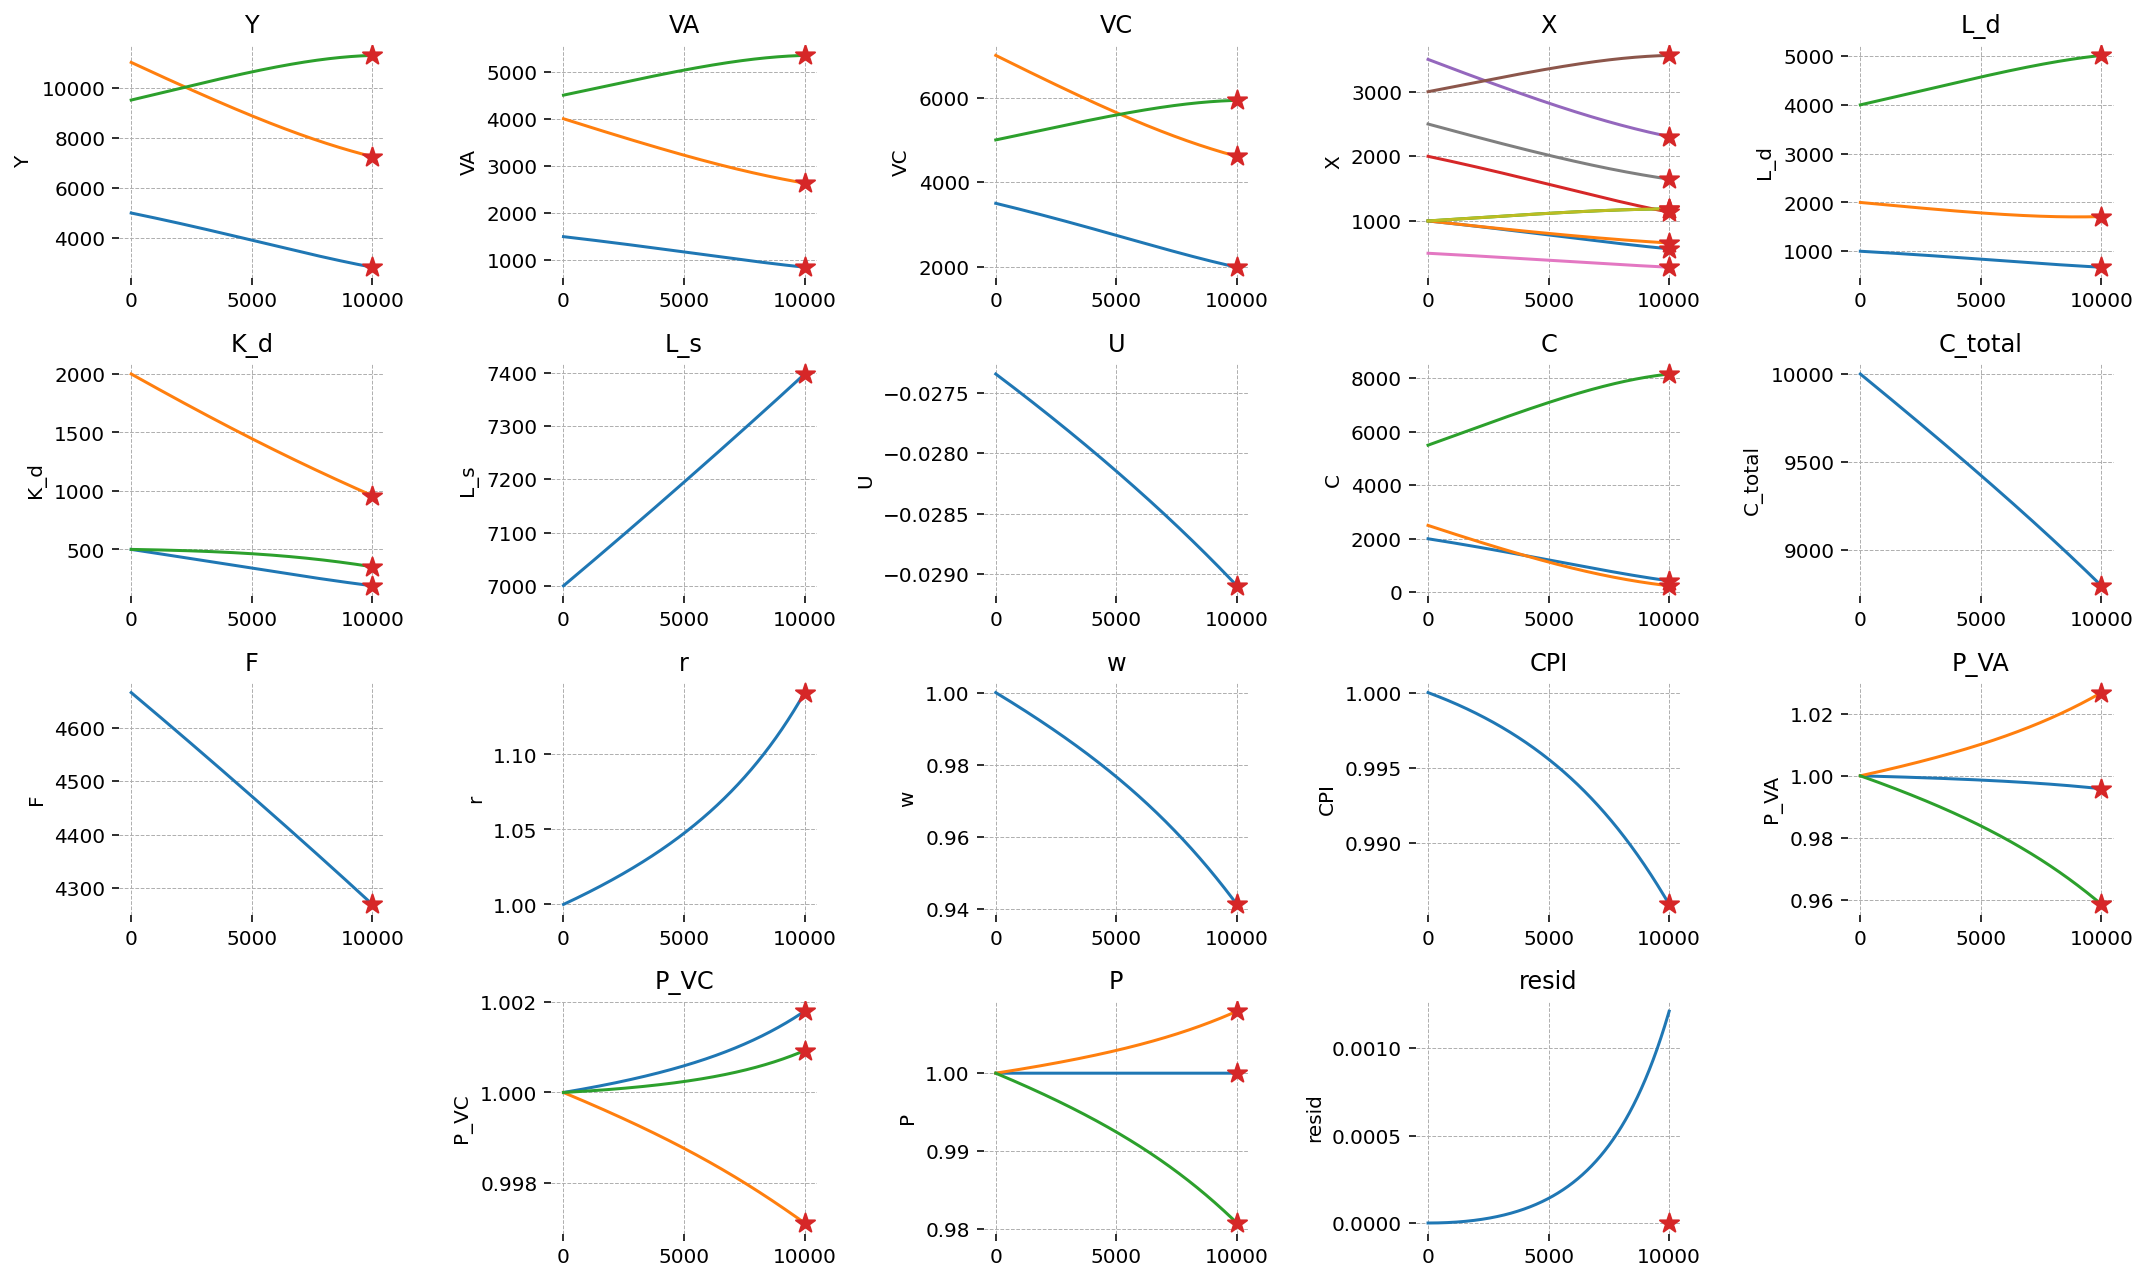

In [13]:
cge.plot_lines(capital_shock, mod)

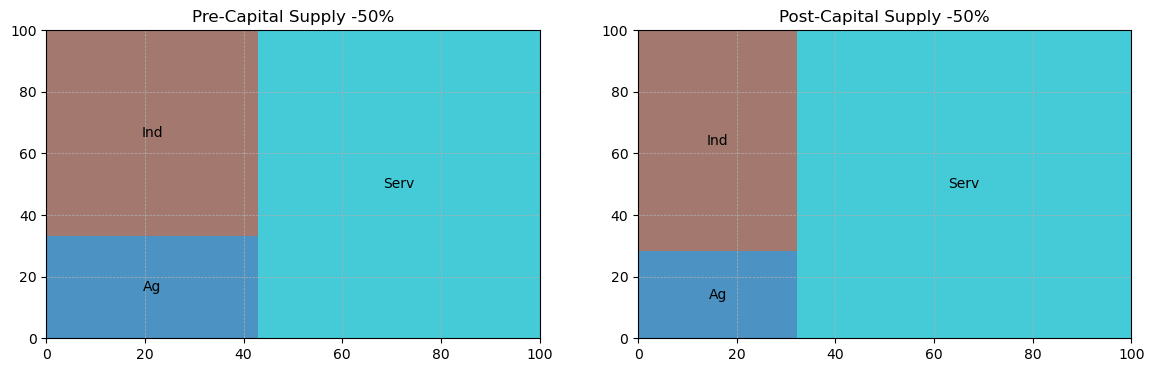

In [14]:
cge.plot_kateplot(
    capital_shock,
    initial_values=calibrated_data,
    var_names=["L_d"],
    shock_name="Capital Supply -50%",
    mod=mod,
)